# Predict disaster tweets with machine learning

**Table of Contents**
<ul>
    <li><a href ="#intro">Introduction</a></li>
    <li><a href ="#wrangle">Wrangling</a></li>
    <li><a href ="#extract">Feature Extraction</a></li>
    <li><a href ="#modelling">Modelling</a></li>
</ul>

<a id ="intro"></a>
## Introduction
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import neattext.functions as nfx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

warnings.filterwarnings('ignore')

In [6]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [10]:
print('test data ', df_test.shape)
print('train data ', df_train.shape)
df_test.head()

test data  (3263, 4)
train data  (7613, 5)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df = df_train.copy()
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
df.isnull().any().sum()

2

In [15]:
df.columns[df.isnull().any()].to_list()

['keyword', 'location']

In [17]:
df.duplicated().sum()

0

<a id ="wrangle"></a>
## Wrangling

In [19]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [20]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [22]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [23]:
df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [26]:
df['text'].iloc[7600:7609]

7600    Evacuation order lifted for town of Roosevelt:...
7601    #breaking #LA Refugio oil spill may have been ...
7602    a siren just went off and it wasn't the Forney...
7603    Officials say a quarantine is in place at an A...
7604    #WorldNews Fallen powerlines on G:link tram: U...
7605    on the flip side I'm at Walmart and there is a...
7606    Suicide bomber kills 15 in Saudi security site...
7607    #stormchase Violent Record Breaking EF-5 El Re...
7608    Two giant cranes holding a bridge collapse int...
Name: text, dtype: object

#### Clear Noise
- Remove mentions/user handles
- Remove hashtags
- Remove urls
- Remove emojis
- Remove special characters

In [29]:
df['cleaned_text'] = df.text.apply(nfx.remove_hashtags)
df['cleaned_text'] = df.cleaned_text.apply(nfx.remove_emojis)
df['cleaned_text'] = df.cleaned_text.apply(nfx.remove_userhandles)
df['cleaned_text'] = df.cleaned_text.apply(nfx.remove_multiple_spaces)
df['cleaned_text'] = df.cleaned_text.apply(nfx.remove_urls)
df['cleaned_text'] = df.cleaned_text.apply(nfx.remove_puncts)
df.head()

,id,keyword,location,text,target,hashtags,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[#earthquake],Our Deeds are the Reason of this May ALLAH For...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[#wildfires],13000 people receive evacuation orders in Cali...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[#Alaska, #wildfires]",Just got sent this photo from Ruby as smoke fr...


In [30]:
df[['text','cleaned_text']]

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this May ALLAH For...
1,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada
2,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive evacuation orders in Cali...
4,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby as smoke fr...
...,...,...
7608,Two giant cranes holding a bridge collapse int...,Two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...,The out of control wild fires in California e...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,M194 [01:04 UTC]5km S of Volcano Hawaii
7611,Police investigating after an e-bike collided ...,Police investigating after an ebike collided w...


<AxesSubplot:>

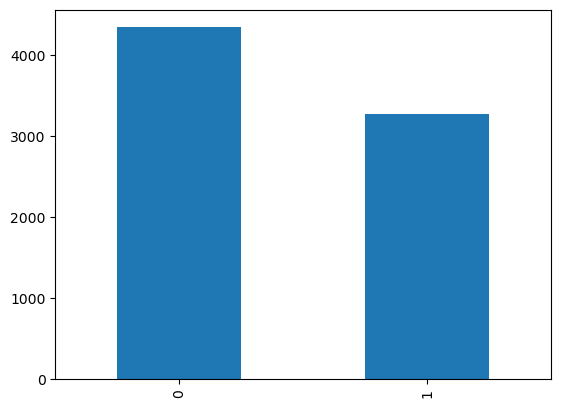

In [37]:
df.target.value_counts().plot(kind='bar')

<a id ="extract"></a>
## Feature Extraction

In [38]:
tfidf = TfidfVectorizer(stop_words='english')

X = df['cleaned_text']
y = df['target']

In [39]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 0)

#apply feature extraxtion on train set
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [40]:
print(len(y_train))
print(len(y_test))

6090
1523


<a id ="modelling"></a>
## Modelling

In [41]:
def classification(model, X, y):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('-Classification Report-\n')
    print(classification_report(y_test, y_pred))
    
    print('Accuracy= ', accuracy_score(y_test, y_pred)*100, '%\n')
    
    print('-Confusion Matrix-\n')
    cm=confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

### Random Forest

-Classification Report-

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       886
           1       0.74      0.67      0.70       637

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

Accuracy=  76.36244254760342 %

-Confusion Matrix-



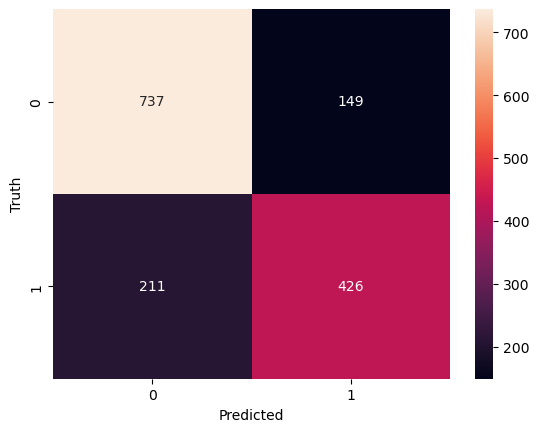

In [42]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(n_estimators = 100, criterion = 'entropy' , random_state = 0)
classification(RF, X, y)

### Naive bayes


-Classification Report-

              precision    recall  f1-score   support

           0       0.77      0.89      0.82       886
           1       0.80      0.63      0.71       637

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523

Accuracy=  78.00393959290874 %

-Confusion Matrix-



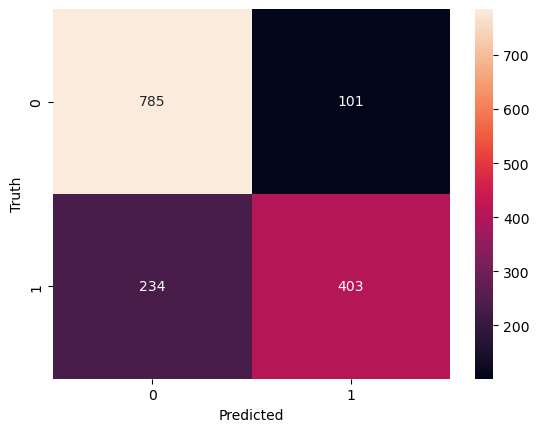

In [43]:
from sklearn.naive_bayes import MultinomialNB

NB=MultinomialNB()
classification(NB, X, y)

### support vector machine


-Classification Report-

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       886
           1       0.85      0.61      0.71       637

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79      0.78      1523

Accuracy=  78.98883782009193 %

-Confusion Matrix-



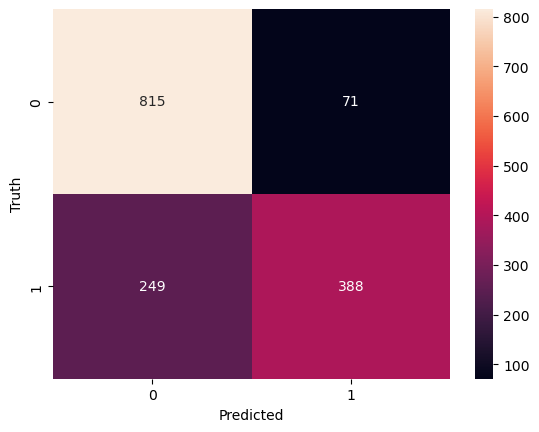

In [44]:
from sklearn.svm import SVC

SVM = SVC(kernel = 'rbf', random_state = 0)
classification(SVM, X, y)

### Decision Tree


-Classification Report-

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       886
           1       0.64      0.69      0.66       637

    accuracy                           0.71      1523
   macro avg       0.70      0.70      0.70      1523
weighted avg       0.71      0.71      0.71      1523

Accuracy=  70.71569271175312 %

-Confusion Matrix-



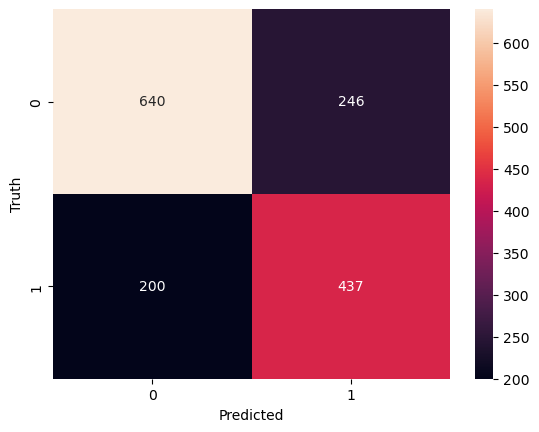

In [45]:
from sklearn.tree import DecisionTreeClassifier

DT= DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classification(DT, X, y)

### Logistic Regression


-Classification Report-

               precision    recall  f1-score   support

           0       0.78      0.90      0.84       886
           1       0.83      0.64      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Accuracy=  79.31713722915299 %

-Confusion Matrix-



Text(50.722222222222214, 0.5, 'Truth')

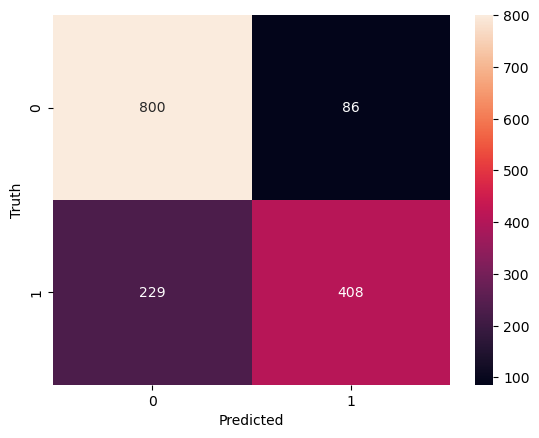

In [47]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred= LR.predict(X_test)

print('-Classification Report-\n\n',classification_report(y_test, y_pred))

print('Accuracy= ', accuracy_score(y_test, y_pred)*100, '%\n')
    
print('-Confusion Matrix-\n')
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')